In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from prettyplotlib import *
import math
from copy import deepcopy as dc
plt.rcParams['figure.figsize'] = (14,8)

In [2]:
data_files = glob.glob("*.txt")

In [17]:
def read_perf_data(file_name):
    empty_counter = {'CPU4':[], 'CPU5':[], 'CPU6':[], 'CPU7':[]}
    perf_data = {'IPC':dc(empty_counter)}
    with open(file_name, 'r') as f:
        for line in f:
            if 'CPU' in line and line.strip()[0].isdigit():
                line = ' '.join(line.replace(',','').split()).split(' ')
                cpu = line[1]
                counter = line[3]
                counter_val = float(line[2])
                if counter == 'cycles':
                    perf_data['IPC'][cpu].append(counter_val)
                elif counter == 'instructions':
                    perf_data['IPC'][cpu][-1] = (counter_val)/perf_data['IPC'][cpu][-1]
                    if perf_data['IPC'][cpu][-1] > 2.0:
                        print("Alert!")
                        print(perf_data['IPC'][cpu][-1])
                        print(line)
                #General perf counter handling:
                if counter not in perf_data:
                    perf_data[counter] = dc(empty_counter)
                perf_data[counter][cpu].append(counter_val)    
    return perf_data

# This version is for comma separated perf files generated
# with the perf stat -x flag
def read_perf_data_separated(file_name):
    perf_data = {}
    IPCs = {'CPU4':[], 'CPU5':[], 'CPU6':[], 'CPU7':[]}
#     Instructions = {'CPU4':[], 'CPU5':[], 'CPU6':[], 'CPU7':[]}
    Branches = {'CPU4':[], 'CPU5':[], 'CPU6':[], 'CPU7':[]}
    LLC_misses = {'CPU4':[], 'CPU5':[], 'CPU6':[], 'CPU7':[]}
    with open(file_name, 'r') as f:
        for line in f:
            if 'CPU' in line and line.strip()[0].isdigit():
                cpu = line.strip().split(',')[1]
                if 'cycles' in line:
                    IPCs[cpu].append(float(line.strip().split(',')[2]))
                elif 'instructions' in line:
                    IPCs[cpu][-1] = (float(line.strip().split(',')[2]))/IPCs[cpu][-1]
                    if IPCs[cpu][-1] > 5:
                        print("Alert!")
                        print(IPCs[cpu][-1])
                        print(float(line.strip().split(',')[2]))
                        print(1/(IPCs[cpu][-1] / float(line.strip().split(',')[2])))
                        print(cpu)
                        print(line)
                elif 'branch-misses' in line:
                    Branches[cpu].append(float(line.strip().split(',')[2]))
                elif 'LLC-load-misses' in line:
                    LLC_misses[cpu].append(float(line.strip().split(',')[2]))
                
    perf_data['IPC'] = IPCs
    perf_data['branch-misses'] = Branches
    perf_data['LLC-load-misses'] = LLC_misses
#     {cpu:(np.array(Instructions[cpu]) / np.array(Cycles[cpu]))\
#                             for cpu in Instructions}
#     print([len(r['CPU7']) for key, r in perf_data.items()])
    
    return perf_data

def plot_counter(perf_data, counter_names, cpu_names, show=True, normalize=False, save=False, title=""):
    if len(title) > 0:
        title = title[0:title.rindex(".")]
    if len(counter_names) == 0 or len(cpu_names) == 0:
        print("Error: no counter names or cpu names supplied")
        return
    for counter in counter_names:
        if counter not in perf_data:
            print("Error: {} not in supplied data.".format(counter))
            continue
        for cpu in cpu_names:
            if cpu not in perf_data[counter]:
                print("Error: {} not in supplied data for counter {}.".format(cpu, counter))
                continue
            if not normalize:
                plt.plot(perf_data[counter][cpu], label="{}: {}".format(cpu, counter))
            else:
                temp = np.array(perf_data[counter][cpu])
                temp /= temp.max()
                plt.plot(temp, label="{}: {}".format(cpu, counter))
            plt.hold(True)
    plt.legend()
    plt.title(title)
    if save:
        plt.savefig(title+"_plot.png", bbox_inches='tight')
    if show:
        plt.hold(False)
        plt.show()

# def hurst_exp(series):
#     arr_series = np.array(series)
#     N = len(series)
#     for d in [2**e for e in range(0,math.floor(math.log(N, 2))+1)]:
#         print(d)
# #     m = arr_series.mean()
# #     adj_series = arr_series - mean
    
    
    


## Using data for blacksholes and bodytrack benchmarks, each run at 2GHz and 800 MHz
### Statistics under consideration are:
* IPC
* Instructions
* Cycles
* page-faults
* LLC-load-misses
* branch-misses
* branches

In [4]:
# read the data
print("Reading:")
for f in data_files:
    print(f)
series_data = {x:read_perf_data(x) for x in data_files}
print("Counters detected:")
for k in series_data:
    for c in series_data[k]:
        print(c)
    break

Reading:
blackscholes_200ms_2GHz_HWP2A.txt
blackscholes_200ms_800MHz_HWP2A.txt
bodytrack_200ms_2GHz_HWP2A.txt
bodytrack_200ms_800MHz_HWP2A.txt
Counters detected:
IPC
cycles
instructions
page-faults
LLC-load-misses
branch-misses
branches


## Following are plots for IPC for all CPUs in each benchmark at each frequency setting:

#### Across the four big cores, blacksholes shows clear phases of computation by IPC level. The master thread during the pre- and post- ROI regions can also be identified, and the core on which this thread operates changes.

#### Bodytrack does not show as distinct phases in computation, and also does not exhibit a coordinating master thread from IPC stats. At the lower frequency point, the maximum IPC is higher possible due to a better matching between memory/IO and CPU speed.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


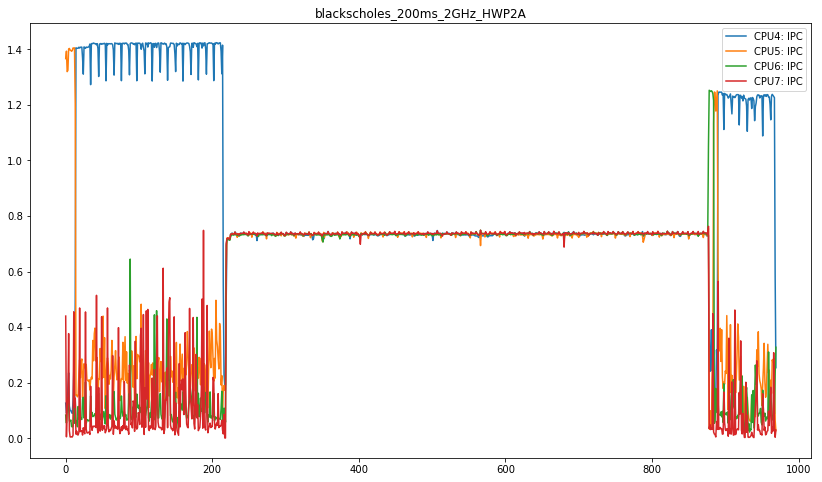

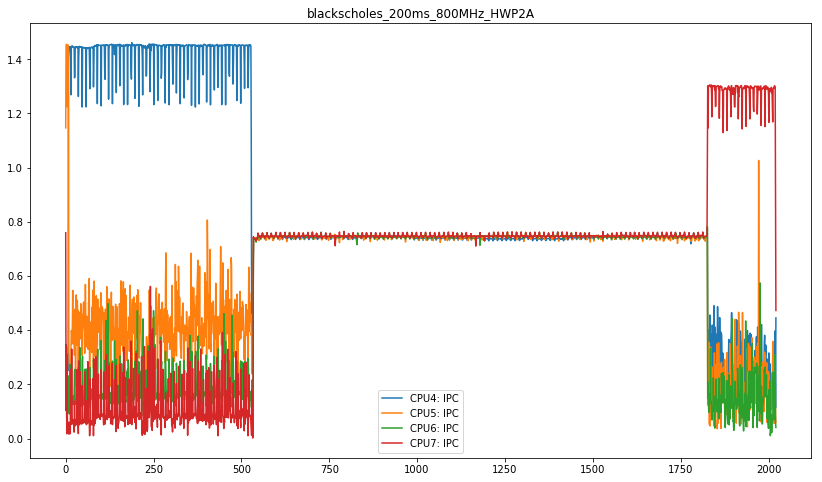

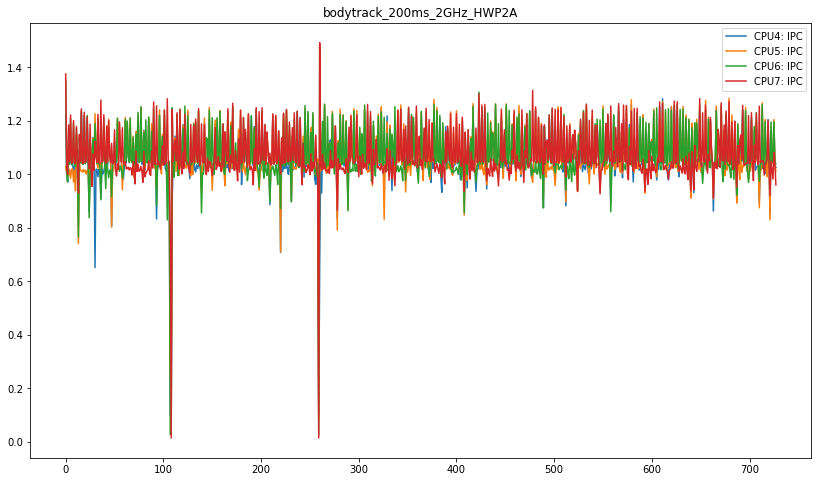

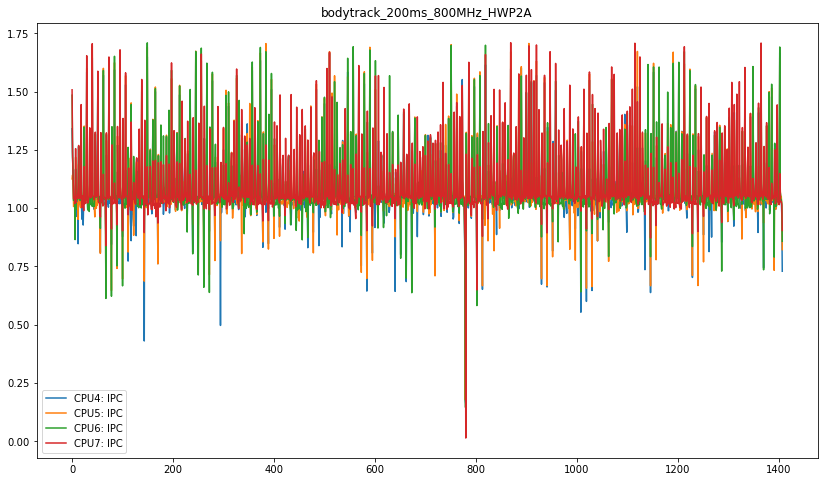

In [18]:
# plot the data for IPC for both benchmarks
counters = ['IPC']
cpus = ['CPU4', 'CPU5', 'CPU6','CPU7']
for i in range(len(data_files)):
    plot_counter(series_data[data_files[i]], counters, cpus, show=True, normalize=False, title=data_files[i])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


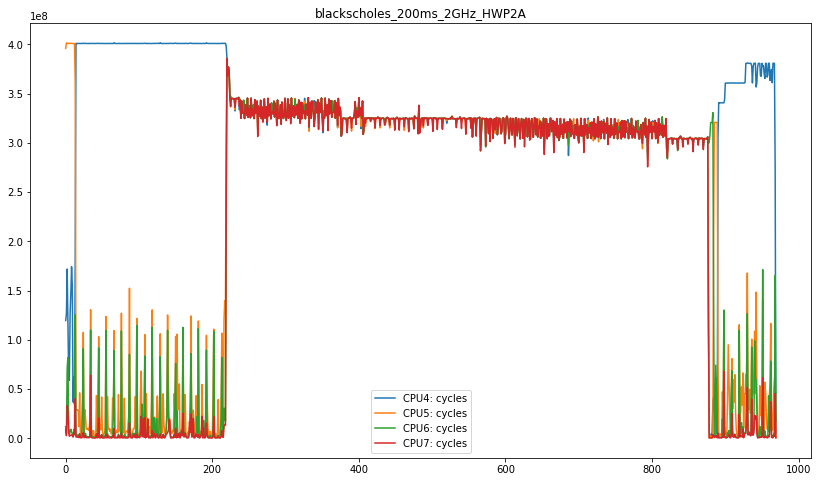

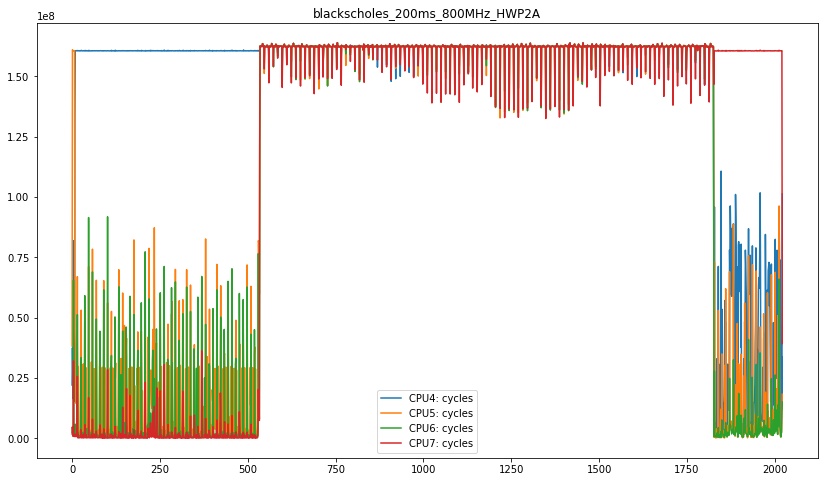

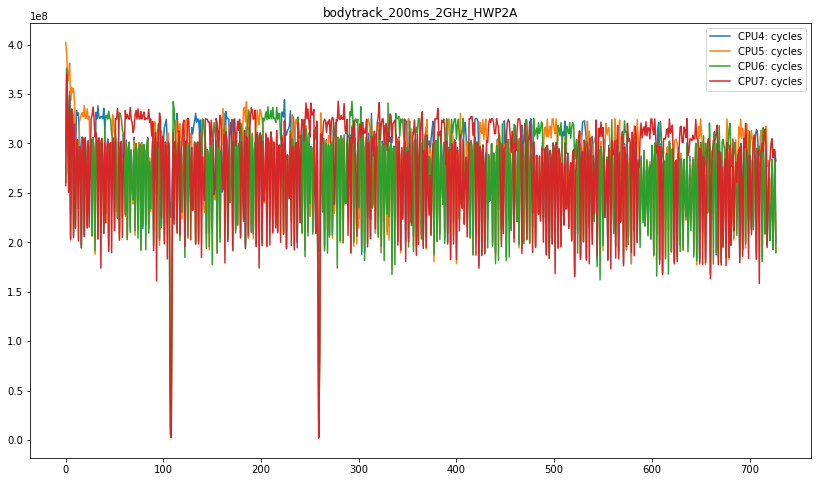

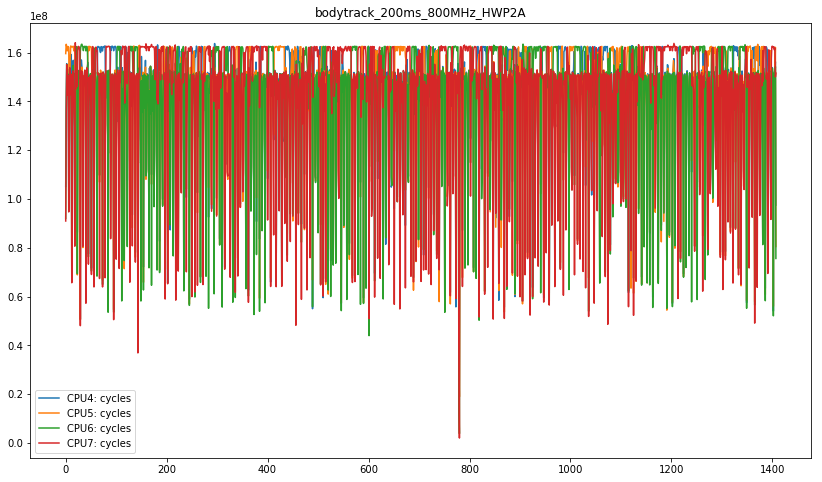

In [19]:
# plot the data for CPU4 page-faults for both benchmarks
# The first plots at 2GHz show the throttling that occurs
counters = ['cycles']
cpus = ['CPU4', 'CPU5', 'CPU6','CPU7']
for i in range(len(data_files)):
    plot_counter(series_data[data_files[i]], counters, cpus, save=True, show=True, normalize=False, title=data_files[i])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


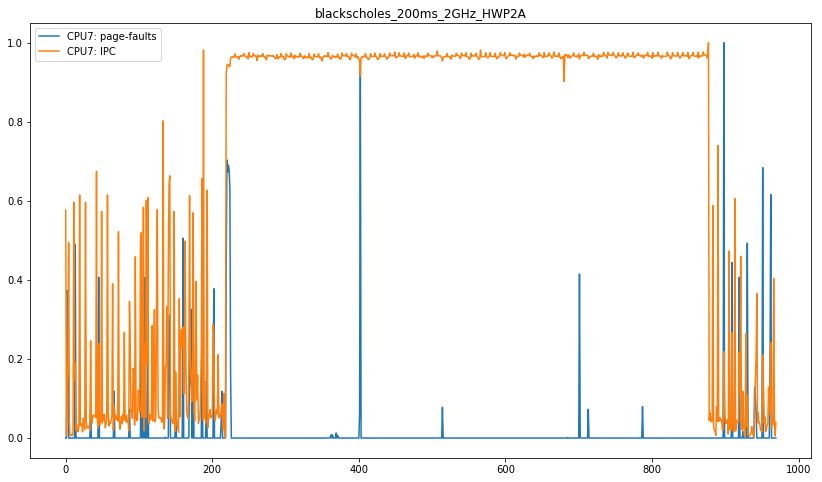

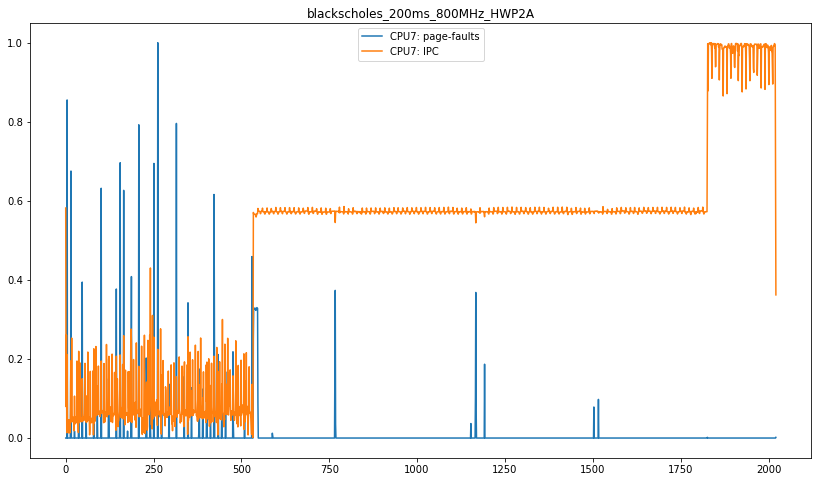

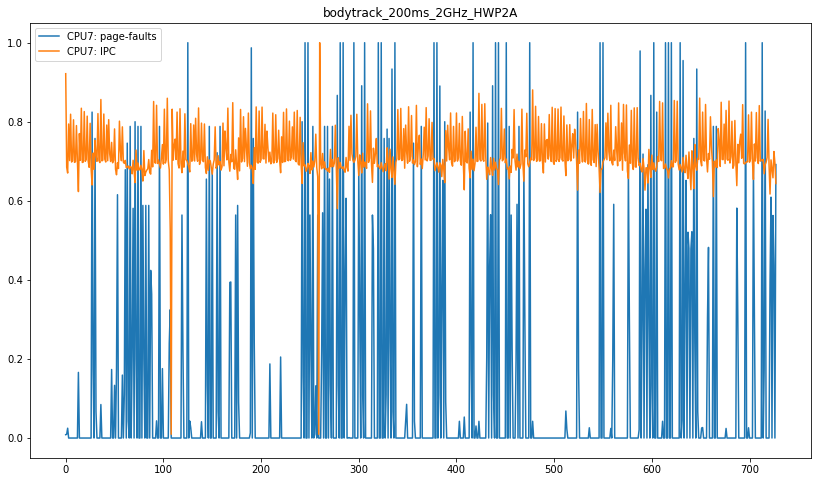

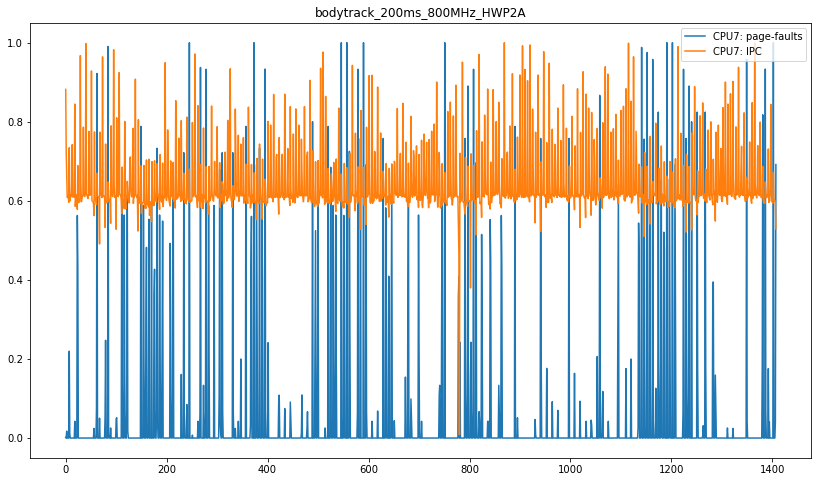

In [25]:
# plot the data for CPU4 page-faults for both benchmarks
counters = ['page-faults', 'IPC']
cpus = ['CPU7']
for i in range(len(data_files)):
    plot_counter(series_data[data_files[i]], counters, cpus, save=True, show=True, normalize=True, title=data_files[i])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


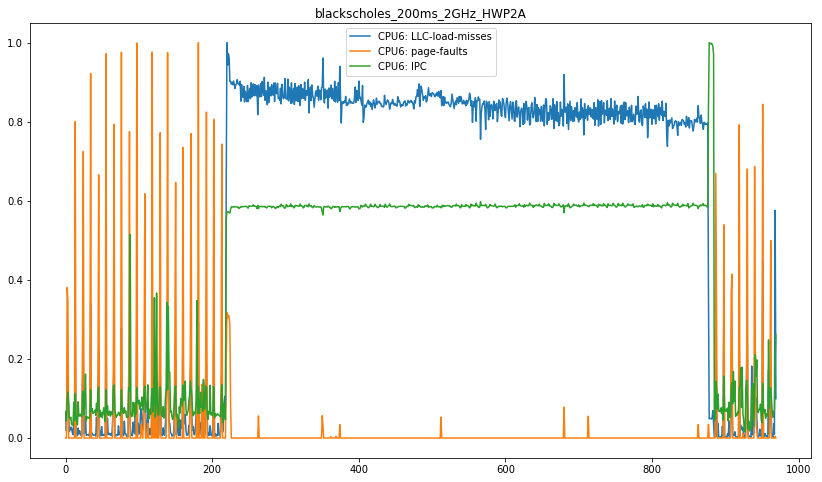

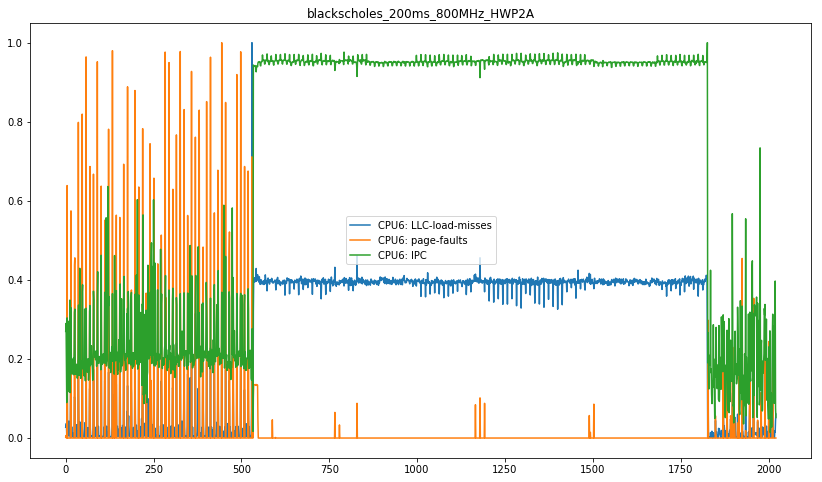

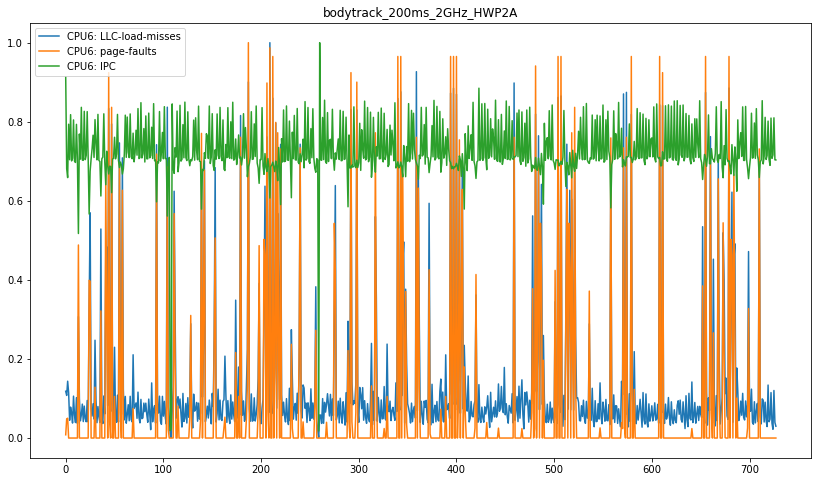

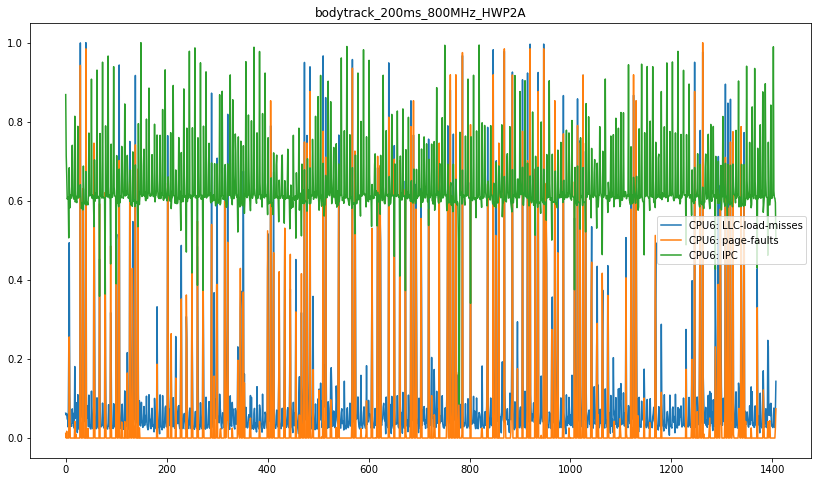

In [26]:
# plot the data for CPU4 ?? for both benchmarks
counters = ['LLC-load-misses', 'page-faults', 'IPC']
cpus = ['CPU6']#, 'CPU5', 'CPU6','CPU7']
for i in range(len(data_files)):
    plot_counter(series_data[data_files[i]], counters, cpus, show=True, normalize=True, title=data_files[i])

In [27]:
# https://pypi.python.org/pypi/nolds/0.1.1
# https://cschoel.github.io/nolds/nolds.html
import nolds
help(nolds.hurst_rs)

Help on function hurst_rs in module nolds.measures:

hurst_rs(data, nvals=None, fit='RANSAC', debug_plot=False, debug_data=False, plot_file=None, corrected=True, unbiased=True)
    Calculates the Hurst exponent by a standard rescaled range (R/S) approach.
    
    Explanation of Hurst exponent:
      The Hurst exponent is a measure for the "long-term memory" of a
      time series, meaning the long statistical dependencies in the data that do
      not originate from cycles.
    
      It originates from H.E. Hursts observations of the problem of long-term
      storage in water reservoirs. If x_i is the discharge of a river in year i
      and we observe this discharge for N years, we can calculate the storage
      capacity that would be required to keep the discharge steady at its mean
      value.
    
      To do so, we first substract the mean over all x_i from the individual
      x_i to obtain the departures x'_i from the mean for each year i. As the
      excess or deficit in 

In [28]:
nolds.corr_dim(series_data[data_files[0]]['IPC']['CPU4'])

TypeError: corr_dim() missing 1 required positional argument: 'emb_dim'

In [29]:
cpu = 'CPU4'
counter = 'IPC'
for i in range(len(data_files)):
    print("DFA on {} {}: {}".format(data_files[i], counter, \
        nolds.dfa(series_data[data_files[i]][counter][cpu]) ) )
    print("Hurst exponent of {} {}: {}".format(data_files[i], counter, \
        nolds.hurst_rs(series_data[data_files[i]][counter][cpu]) ) )

DFA on blackscholes_200ms_2GHz_HWP2A.txt IPC: 1.4504682190257754
Hurst exponent of blackscholes_200ms_2GHz_HWP2A.txt IPC: 0.7566895318384924
DFA on blackscholes_200ms_800MHz_HWP2A.txt IPC: 1.1536493240933408
Hurst exponent of blackscholes_200ms_800MHz_HWP2A.txt IPC: 0.6282652431198638
DFA on bodytrack_200ms_2GHz_HWP2A.txt IPC: 0.622283770545026
Hurst exponent of bodytrack_200ms_2GHz_HWP2A.txt IPC: 0.44068453321314727
DFA on bodytrack_200ms_800MHz_HWP2A.txt IPC: 0.46905581549631753
Hurst exponent of bodytrack_200ms_800MHz_HWP2A.txt IPC: 0.38668042222171417


In [123]:
cpu = 'CPU4'
counter = 'page-faults'
for i in range(len(data_files)):
    print("DFA on {} {}: {}".format(data_files[i], counter, \
        nolds.dfa(series_data[data_files[i]][counter][cpu]) ) )
    print("Hurst exponent of {} {}: {}".format(data_files[i], counter, \
        nolds.hurst_rs(series_data[data_files[i]][counter][cpu]) ) )

DFA on blackscholes_200ms_2GHz_HWP2A.txt page-faults: 1.3235858350026934
Hurst exponent of blackscholes_200ms_2GHz_HWP2A.txt page-faults: 0.6083431909613459
DFA on blackscholes_200ms_800MHz_HWP2A.txt page-faults: 1.1218943609230816
Hurst exponent of blackscholes_200ms_800MHz_HWP2A.txt page-faults: 0.3929216301484506
DFA on bodytrack_200ms_2GHz_HWP2A.txt page-faults: 0.7824385875836458
Hurst exponent of bodytrack_200ms_2GHz_HWP2A.txt page-faults: 0.4621479288016981
DFA on bodytrack_200ms_800MHz_HWP2A.txt page-faults: 0.6724519597434803
Hurst exponent of bodytrack_200ms_800MHz_HWP2A.txt page-faults: 0.5883022661303136


In [111]:
help(nolds)

Help on package nolds:

NAME
    nolds

PACKAGE CONTENTS
    datasets
    examples
    measures
    test_measures

DATA
    brown72 = array([ 45.47422,  42.55601,  46.5188 , ...,  42.78297,  44....

FILE
    c:\programdata\anaconda3\lib\site-packages\nolds\__init__.py


